# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [29]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [30]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [31]:
d.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [32]:
%%writefile home/height_1_ppc.stan
generated quantities {
    real mu = normal_rng(160, 10);
    real sigma = normal_rng(15, 3);
    real height = normal_rng(mu, sigma);
}

Overwriting home/height_1_ppc.stan


## Task 1. Prior predictive checks

In [33]:
model_ppc=CmdStanModel(stan_file='home/height_1_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/height_1_ppc.stan to exe file /home/height_1_ppc


INFO:cmdstanpy:compiled model executable: /home/height_1_ppc


In [34]:
R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

In [35]:
sim.draws_pd()

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,187.082,17.3315,165.031
1,0.0,0.0,161.276,10.8317,163.942
2,0.0,0.0,171.987,21.7960,193.148
3,0.0,0.0,165.554,16.7968,165.184
4,0.0,0.0,173.120,13.9736,168.773
...,...,...,...,...,...
995,0.0,0.0,159.728,16.5634,172.725
996,0.0,0.0,155.939,11.4199,159.066
997,0.0,0.0,153.635,14.6963,154.681
998,0.0,0.0,160.092,15.7439,136.057


In [36]:
df = pd.DataFrame((sim.draws()[:, :, 2:]).reshape(1000, 3), columns=sim.column_names[2:])
df

,mu,sigma,height
0,187.082,17.3315,165.031
1,161.276,10.8317,163.942
2,171.987,21.7960,193.148
3,165.554,16.7968,165.184
4,173.120,13.9736,168.773
...,...,...,...
995,159.728,16.5634,172.725
996,155.939,11.4199,159.066
997,153.635,14.6963,154.681
998,160.092,15.7439,136.057


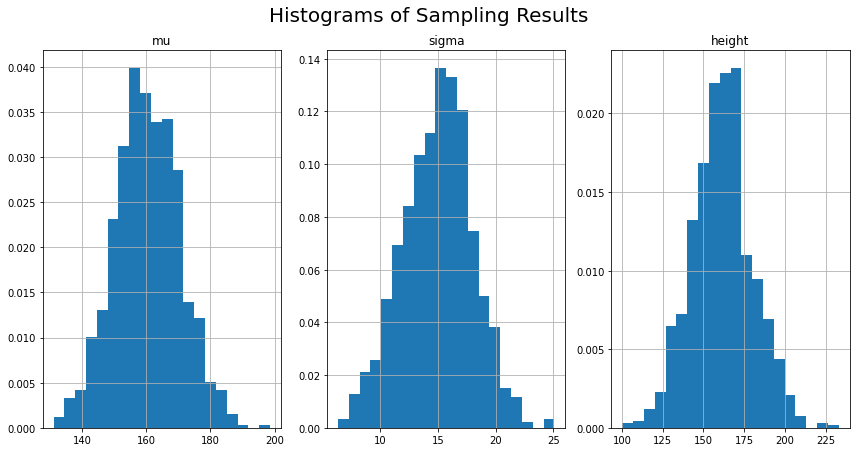

In [37]:
df.hist(figsize=(12, 6), layout=(1, 3), bins=20, density=True)
plt.tight_layout()
plt.suptitle('Histograms of Sampling Results', y=1.04, fontsize=20)
plt.show()

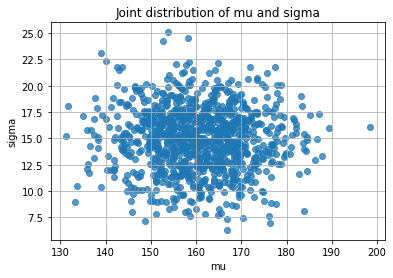

In [38]:
plt.figure()
plt.scatter(df['mu'], df['sigma'], alpha=0.75)
plt.title("Joint distribution of mu and sigma")
plt.xlabel("mu")
plt.ylabel("sigma")
plt.grid()
plt.show()

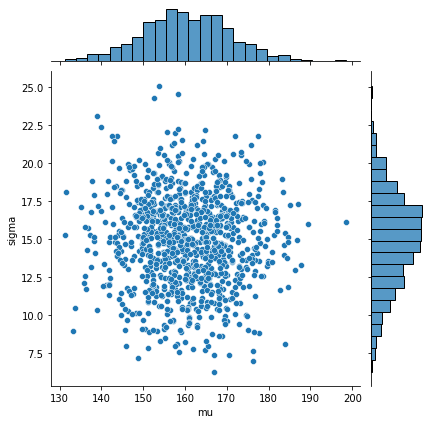

In [39]:
sns.jointplot(data=sim.draws_pd(), x=df['mu'], y=df['sigma'])
plt.xlabel("mu")
plt.ylabel("sigma")
plt.show()

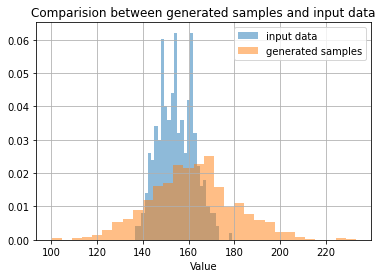

In [40]:
d['height'].hist(density=True, bins=30, alpha=0.5, label='input data')
sim.draws_pd()['height'].hist(density=True, bins=30, alpha=0.5, label='generated samples')
plt.legend()
plt.xlabel("Value")
plt.title("Comparision between generated samples and input data")
plt.show()

Generated samples are not consistent with input data at all, and it's challenging to find a values of parameters that can generate samples which match the data in a better way.

## Task 2. Model fit and evaluation

In [41]:
%%writefile home/height_1_fit.stan
data {
    int<lower=0> N;
    array [N] real<lower=0> heights;
}

parameters {
    real<lower=0> mu;
    real<lower=0> sigma; 
}

model {
    mu ~ normal(160, 10);
    sigma ~ exponential(0.3);
    heights ~ normal(mu, sigma);
}

generated quantities {
    real<lower=0> fit_height = normal_rng(mu, sigma);
}

Overwriting home/height_1_fit.stan


In [42]:
model_1_fit=CmdStanModel(stan_file='home/height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /home/height_1_fit.stan to exe file /home/height_1_fit


INFO:cmdstanpy:compiled model executable: /home/height_1_fit


In [43]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


In [44]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,fit_height
0,-891.387,0.885766,0.76679,2.0,3.0,0.0,892.318,154.562,7.82197,148.872
1,-891.614,0.939220,0.76679,2.0,5.0,0.0,891.781,154.462,7.52350,137.409
2,-892.428,0.851647,0.76679,2.0,3.0,0.0,892.500,154.054,7.55282,151.990
3,-891.905,1.000000,0.76679,1.0,1.0,0.0,892.410,154.188,7.62103,155.443
4,-891.629,0.931229,0.76679,2.0,3.0,0.0,892.542,154.918,7.79261,148.532


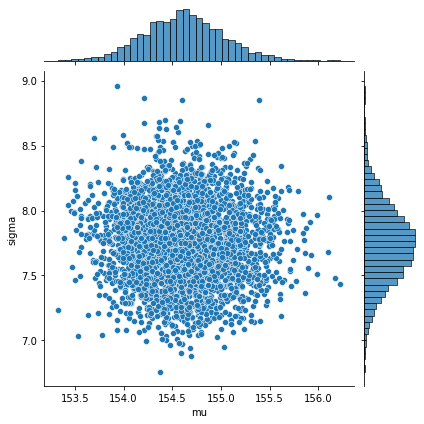

In [45]:
sns.jointplot(data=fit.draws_pd(), x=df['mu'], y=df['sigma'])
plt.xlabel("mu")
plt.ylabel("sigma")
plt.show()


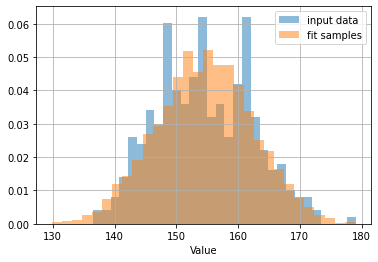

In [46]:
d['height'].hist(density=True, bins=30, alpha=0.5, label='input data')
fit.draws_pd()['fit_height'].hist(density=True, bins=30, alpha=0.5, label='fit samples')
plt.legend()
plt.xlabel("Value")
plt.show()

After fitting the model, generated samples definitely better match input data.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [47]:
d['c_weight'] = d['weight'] - d['weight'].mean()
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

## Task 4. Prior predictive checks
 

In [48]:
%%writefile home/height_2a_ppc.stan
data {
    int<lower=0> N;
    array [N] real weight;
}

generated quantities {
    real alpha = normal_rng(160, 10);
    real beta = normal_rng(0, 1);
    real sigma = exponential_rng(0.3);
    array [N] real height;
    for (i in 1:N) {
        height[i] = normal_rng(alpha + beta * weight[i], sigma);
    }
}

Overwriting home/height_2a_ppc.stan


In [49]:
model_ppc=CmdStanModel(stan_file='home/height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=1, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/height_2a_ppc.stan to exe file /home/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /home/height_2a_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [50]:
df = sim.draws_pd()
df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,187.082,0.777181,5.183190,176.925,169.568,178.552,183.996,190.031,...,202.543,206.781,205.508,199.382,191.375,196.256,198.143,204.019,202.045,204.409
1,0.0,0.0,148.011,-0.006780,0.019421,148.129,148.115,148.111,148.115,148.111,...,147.980,147.924,147.902,147.912,147.892,147.916,147.882,147.896,147.918,147.887
2,0.0,0.0,155.730,-1.138640,4.546810,178.020,169.982,169.367,172.106,170.404,...,149.860,135.140,147.306,141.212,147.845,138.245,141.982,138.758,135.793,136.203
3,0.0,0.0,150.179,-0.254452,1.432820,155.625,152.609,153.077,151.857,152.741,...,147.890,147.146,147.320,148.649,145.797,145.574,147.374,145.243,146.345,145.087
4,0.0,0.0,150.066,1.671020,2.223360,121.002,126.580,127.240,128.351,134.038,...,173.845,174.353,170.902,174.013,174.399,174.791,175.701,179.655,180.338,178.338


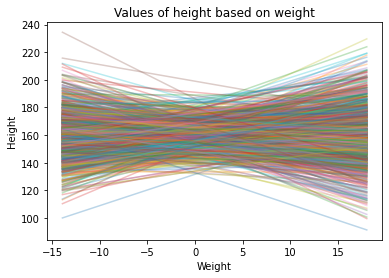

In [51]:
alpha = df['alpha'].values
beta = df['beta'].values
weigth_vector_lower_bound = np.min(d.c_weight)
weigth_vector_upper_bound = np.max(d.c_weight)
weight_vector = np.linspace(weigth_vector_lower_bound, weigth_vector_upper_bound, R).reshape(R, 1)
heights = alpha + beta * weight_vector
plt.plot(weight_vector, heights, alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Values of height based on weight")
plt.show()

In [52]:
maximum_height_observed = 0
maximum_height_observed = 272
heights_min = np.min(df.loc[:, 'height[1]':'height[50]'].values)
heights_min

81.6492

In [53]:
heights_max = np.max(df.loc[:, 'height[1]':'height[50]'].values)
heights_max

239.012

Predicted heights are within the limits that occur in the nature.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [54]:
%%writefile home/height_2b_ppc.stan
data {
    int<lower=0> N;
    array [N] real weight;
}

generated quantities {
    real alpha = normal_rng(160, 10);
    real beta = lognormal_rng(0, 1);
    real sigma = exponential_rng(0.3);
    array [N] real height;
    for (i in 1:N) {
        height[i] = normal_rng(alpha + beta * weight[i], sigma);
    }
}

Overwriting home/height_2b_ppc.stan


In [55]:
model_ppc=CmdStanModel(stan_file='home/height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/height_2b_ppc.stan to exe file /home/height_2b_ppc


INFO:cmdstanpy:compiled model executable: /home/height_2b_ppc


In [56]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=1, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [57]:
df = sim.draws_pd()
df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,187.082,2.175330,5.183190,157.4640,151.0180,160.9130,167.2670,174.2130,...,219.515,224.664,224.301,219.087,211.991,217.782,220.580,227.367,226.304,229.578
1,0.0,0.0,148.011,0.993243,0.019421,134.2090,134.8470,135.4940,136.1490,136.7970,...,160.120,160.714,161.344,162.006,162.637,163.313,163.930,164.595,165.269,165.890
2,0.0,0.0,155.730,0.320255,4.546810,157.7130,150.6250,150.9610,154.6500,153.8980,...,167.569,153.800,166.916,161.772,169.356,160.706,165.394,163.120,161.106,162.466
3,0.0,0.0,150.179,0.775342,1.432820,141.2910,138.9460,140.0840,139.5360,141.0910,...,160.391,160.317,161.162,163.162,160.981,161.429,163.900,162.440,164.213,163.626
4,0.0,0.0,150.066,5.317560,2.223360,70.2445,78.1974,81.2336,84.7202,92.7829,...,218.111,220.994,219.919,225.405,228.166,230.934,234.219,240.550,243.608,243.984


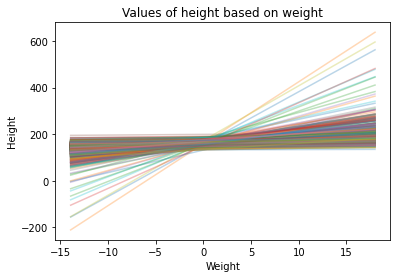

In [58]:
alpha = df['alpha'].values
beta = df['beta'].values
weigth_vector_lower_bound = np.min(d.c_weight)
weigth_vector_upper_bound = np.max(d.c_weight)
weight_vector = np.linspace(weigth_vector_lower_bound, weigth_vector_upper_bound, R).reshape(R, 1)
heights = alpha + beta * weight_vector
plt.plot(weight_vector, heights, alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Values of height based on weight")
plt.show()

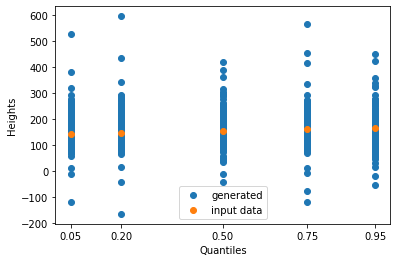

In [59]:
heights = df.loc[:, 'height[1]' : 'height[50]'].values
quantiles = [0.05, 0.2, 0.5, 0.75, 0.95]
simulated_quantiles = np.quantile(a=heights, q=quantiles, axis=1)
input_data_quantiles = np.quantile(a=d['height'].values, q=quantiles, axis=0)

quantiles_reshape = quantiles * np.ones((1000, 1))
plt.scatter(quantiles_reshape, simulated_quantiles, label='generated')
plt.scatter(quantiles, input_data_quantiles, label='input data')
plt.xticks(quantiles)
plt.xlabel("Quantiles")
plt.ylabel("Heights")
plt.legend(loc='best')
plt.show()

The observed data is possible with the prior model.

## Task 6. Fitting and evaluating model


In [60]:
%%writefile home/height_2_fit.stan
data {
    int<lower=0> N;
    array [N] real weights;
    array [N] real<lower=0> heights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma; 
    real<lower=0> beta;
}

transformed parameters {
    array [N] real mu_arr;
    for(i in 1:N) {
        mu_arr[i] = alpha + beta * weights[i];
    }
}

model {
    alpha ~ normal(160, 10);
    sigma ~ exponential(0.3);
    beta ~ lognormal(0, 1);
    for(i in 1:N) {
        heights[i] ~ normal(mu_arr[i], sigma);
    }
}

generated quantities {
    array [N] real<lower=0> fit_height;
    for(i in 1:N) {
        fit_height[i] = normal_rng(mu_arr[i], sigma);
    }
}

Overwriting home/height_2_fit.stan


In [61]:
model_2_fit=CmdStanModel(stan_file='home/height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /home/height_2_fit.stan to exe file /home/height_2_fit


INFO:cmdstanpy:compiled model executable: /home/height_2_fit


In [62]:
N = 50
data_fit={'N':N, 'weights': d['weight'].head(N).values, 'heights':d['height'].head(N).values}

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [63]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)




chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [64]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,fit_height[41],fit_height[42],fit_height[43],fit_height[44],fit_height[45],fit_height[46],fit_height[47],fit_height[48],fit_height[49],fit_height[50]
0,-109.109,0.987809,0.122251,4.0,23.0,0.0,109.860,121.251,5.17055,0.701360,...,145.131,162.427,157.405,152.988,154.643,152.168,154.410,156.998,155.441,154.228
1,-109.269,0.994084,0.122251,5.0,31.0,0.0,109.386,123.734,5.13418,0.649371,...,158.777,155.441,155.100,149.815,157.710,157.441,149.310,164.489,159.230,155.051
2,-109.971,0.828244,0.122251,4.0,19.0,0.0,111.996,125.508,4.88539,0.624117,...,151.146,158.768,155.464,152.821,153.916,156.025,156.631,151.526,157.473,155.618
3,-109.270,0.902762,0.122251,5.0,31.0,0.0,111.125,121.754,4.63927,0.694929,...,153.027,158.885,158.204,147.504,157.052,162.661,155.219,159.298,147.792,155.046
4,-109.836,0.850010,0.122251,2.0,3.0,0.0,109.935,122.246,4.64457,0.700548,...,155.569,162.878,162.852,154.057,161.098,165.527,155.073,161.381,168.543,153.159


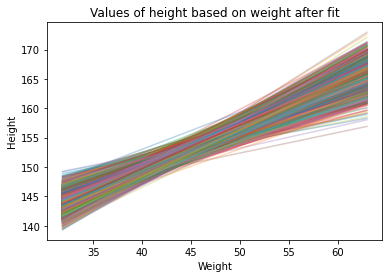

In [65]:
alpha = df['alpha'].values
beta = df['beta'].values
weigth_vector_lower_bound = np.min(data_fit['weights'])
weigth_vector_upper_bound = np.max(data_fit['weights'])
weight_vector = np.linspace(weigth_vector_lower_bound, weigth_vector_upper_bound, N).reshape(N, 1)
fit_heights = alpha + beta * weight_vector
weight_vector = np.ones((1, 4000)) * weight_vector
plt.plot(weight_vector, fit_heights, alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Values of height based on weight after fit")
plt.show()

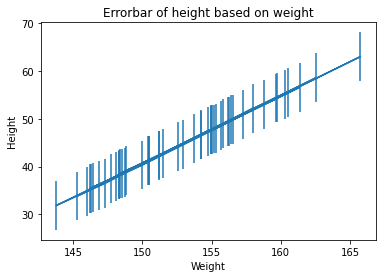

In [66]:
heights = np.mean(df.loc[:,'fit_height[1]':f'fit_height[{N}]'].values, axis=0)
weights = data_fit['weights']
yerr = heights.std(axis=0)

plt.errorbar(x=heights, y=weights, yerr=yerr)
plt.title('Errorbar of height based on weight')
plt.ylabel('Height')
plt.xlabel('Weight')
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)




chain 1 |██████████| 00:01 Iteration: 1900 / 2000 [ 95%]  (Sampling)




chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)



chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |████████


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status

chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ 


INFO:cmdstanpy:CmdStan done processing.


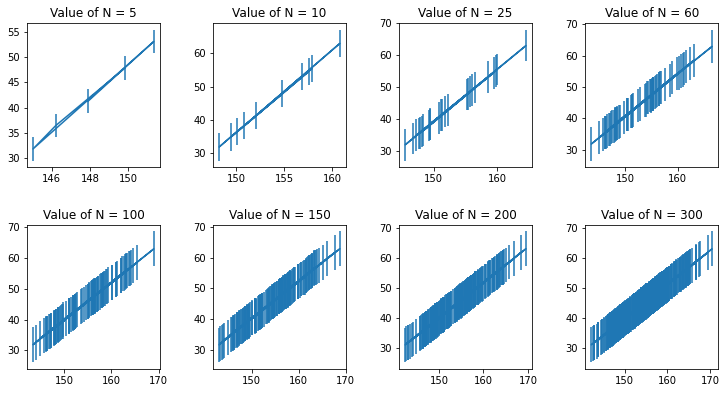

In [67]:
N_vect = [5, 10, 25, 60, 100, 150, 200, 300]
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
ax = ax.flatten()
for i in range(len(N_vect)):
    data_fit={'N':N_vect[i], 'weights': d['weight'].head(N_vect[i]).values, 'heights':d['height'].head(N_vect[i]).values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    heights = np.mean(df.loc[:,'fit_height[1]':f'fit_height[{N_vect[i]}]'].values, axis=0)
    weights = data_fit['weights']
    yerr = heights.std(axis=0)
    ax[i].errorbar(x=heights, y=weights, yerr=yerr)
    ax[i].set_title(f"Value of N = {N_vect[i]}")
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |██████████| 00:00 Sampling completed                     
chain 2 |██████████| 00:00 Sampling completed                       

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)



chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)




chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)



chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |███


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▍    | 00:01 Iteration: 1000 / 2000 [ 50%]  (Warmup)





chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)




chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |███

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)




chain 1 |███████▋  | 00


INFO:cmdstanpy:CmdStan done processing.


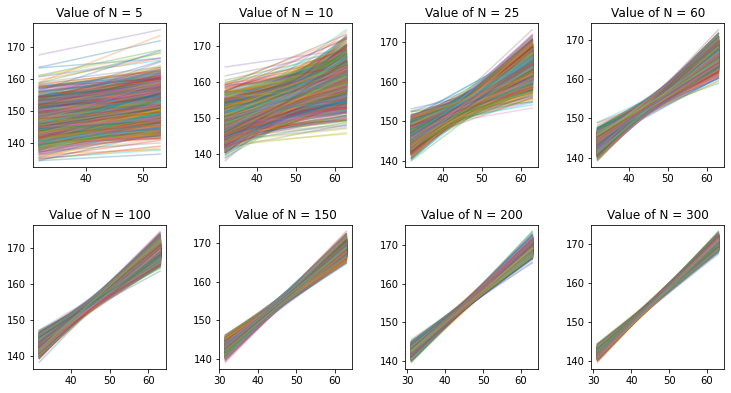

In [68]:
N_vect = [5, 10, 25, 60, 100, 150, 200, 300]
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
ax = ax.flatten()
for i in range(len(N_vect)):
    data_fit={'N':N_vect[i], 'weights': d['weight'].head(N_vect[i]).values, 'heights':d['height'].head(N_vect[i]).values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    alpha = df['alpha'].values
    beta = df['beta'].values
    weigth_vector_lower_bound = np.min(data_fit['weights'])
    weigth_vector_upper_bound = np.max(data_fit['weights'])
    weight_vector = np.linspace(weigth_vector_lower_bound, weigth_vector_upper_bound, N).reshape(N, 1)
    fit_heights = alpha + beta * weight_vector
    weight_vector = np.ones((1, 4000)) * weight_vector
    ax[i].plot(weight_vector, fit_heights, alpha=0.3)
    ax[i].set_title(f"Value of N = {N_vect[i]}")
plt.show()

If the value of N increases then fit of model to the data improves.

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

1. Center the weight data

In [69]:
N = 50 
data_fit={'N':N, 'weights': d['c_weight'].head(N).values, 'heights':d['height'].head(N).values}  
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


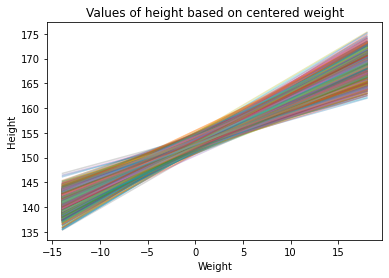

In [70]:
df = fit.draws_pd()
alpha = df['alpha'].values
beta = df['beta'].values
weigth_vector_lower_bound = np.min(d.c_weight)
weigth_vector_upper_bound = np.max(d.c_weight)
weight_vector = np.linspace(weigth_vector_lower_bound, weigth_vector_upper_bound, N).reshape(N, 1)
heights = alpha + beta * weight_vector
plt.plot(weight_vector, heights, alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Values of height based on centered weight")
plt.show()

Parameter &alpha; is the intercept and refers to a parameter that represents the expected value (mean). The model works well with data with centered weights.

Model modified with a second power of weight.

In [71]:
%%writefile home/height_extended_fit.stan
data {
    int<lower=0> N;
    array [N] real weights;
    array [N] real<lower=0> heights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma; 
    real<lower=0> beta;
    real<lower=0> gamma;
}

transformed parameters {
    array [N] real mu_arr;
    for(i in 1:N) {
        mu_arr[i] = alpha + beta * weights[i] + gamma * pow(weights[i], 2);
    }
}

model {
    alpha ~ normal(160, 10);
    sigma ~ exponential(0.3);
    beta ~ lognormal(0, 1);
    gamma ~ lognormal(0, 1);
    for(i in 1:N) {
        heights[i] ~ normal(mu_arr[i], sigma);
    }
}

generated quantities {
    array [N] real<lower=0> fit_height;
    for(i in 1:N) {
        fit_height[i] = normal_rng(mu_arr[i], sigma);
    }
}

Overwriting home/height_extended_fit.stan


In [72]:
extended_fit = CmdStanModel(stan_file='home/height_extended_fit.stan')

INFO:cmdstanpy:compiling stan file /home/height_extended_fit.stan to exe file /home/height_extended_fit


INFO:cmdstanpy:compiled model executable: /home/height_extended_fit


In [73]:
N = 50 
data_fit={'N':N, 'weights': d['c_weight'].head(N).values, 'heights':d['height'].head(N).values}  
fit=extended_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [74]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,fit_height[41],fit_height[42],fit_height[43],fit_height[44],fit_height[45],fit_height[46],fit_height[47],fit_height[48],fit_height[49],fit_height[50]
0,-110.506,0.998073,0.559543,3.0,7.0,0.0,112.277,150.674,4.82429,0.842524,...,152.919,168.437,153.176,151.381,159.453,164.168,162.117,155.953,159.947,152.059
1,-113.048,0.693168,0.559543,3.0,7.0,0.0,114.998,151.542,6.63660,0.901297,...,139.844,170.561,145.373,139.540,168.532,170.523,156.177,148.728,156.821,156.250
2,-111.865,0.982861,0.559543,3.0,7.0,0.0,114.666,150.447,5.33612,0.676911,...,145.284,167.379,152.054,158.397,158.493,156.903,151.824,160.100,154.875,147.540
3,-112.990,0.811858,0.559543,3.0,7.0,0.0,115.264,152.600,4.76896,1.029120,...,148.441,178.207,152.777,151.465,158.920,174.340,147.557,158.512,159.556,155.537
4,-110.249,1.000000,0.559543,2.0,3.0,0.0,112.741,151.707,5.13266,0.885385,...,152.176,162.525,153.796,150.128,161.585,166.281,145.476,154.899,159.096,145.561


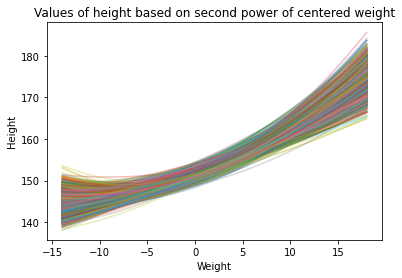

In [75]:
alpha = df['alpha'].values
beta = df['beta'].values
gamma = df['gamma'].values
weigth_vector_lower_bound = np.min(d.c_weight)
weigth_vector_upper_bound = np.max(d.c_weight)
weight_vector = np.linspace(weigth_vector_lower_bound, weigth_vector_upper_bound, N).reshape(N, 1)
heights = alpha + beta * weight_vector + gamma * pow(weight_vector, 2)
plt.plot(weight_vector, heights, alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Values of height based on second power of centered weight")
plt.show()

This model is slightly worse than model with a first power of weights.

Vectorized model

In [76]:
%%writefile home/height_vectorized_fit.stan
data {
    int<lower=0> N;
    vector [N]  weights;
    vector [N]  heights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma; 
    real<lower=0> beta;
    real<lower=0> gamma;
}

transformed parameters {
    vector [N] mu_arr;
    mu_arr = alpha + beta * weights + gamma * pow(weights, 2);
}

model {
    alpha ~ normal(160, 10);
    sigma ~ exponential(0.3);
    beta ~ lognormal(0, 1);
    gamma ~ lognormal(0, 1);
    heights ~ normal(mu_arr, sigma);
}

generated quantities {
    vector [N] fit_height;
    for (i in 1:N){
        fit_height[i] = normal_rng(mu_arr[i], sigma);
    }
}

Overwriting home/height_vectorized_fit.stan


In [77]:
vectorized_fit = CmdStanModel(stan_file='home/height_vectorized_fit.stan')

INFO:cmdstanpy:compiling stan file /home/height_vectorized_fit.stan to exe file /home/height_vectorized_fit
INFO:cmdstanpy:compiled model executable: /home/height_vectorized_fit


In [78]:
N = 50 
data_fit={'N':N, 'weights': d['c_weight'].head(N).values, 'heights':d['height'].head(N).values}  
fit=vectorized_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [79]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,fit_height[41],fit_height[42],fit_height[43],fit_height[44],fit_height[45],fit_height[46],fit_height[47],fit_height[48],fit_height[49],fit_height[50]
0,-112.836,0.999226,0.467571,3.0,7.0,0.0,115.593,152.246,5.38742,0.855944,...,152.258,170.761,146.348,147.314,166.249,161.572,147.561,160.143,159.000,153.217
1,-112.837,0.982731,0.467571,2.0,7.0,0.0,115.814,150.043,5.13705,0.990806,...,142.800,176.024,149.989,143.901,166.241,160.219,150.080,148.184,146.370,151.071
2,-113.761,0.892278,0.467571,3.0,7.0,0.0,116.144,151.795,5.56020,1.019890,...,138.104,171.622,156.695,153.991,152.352,169.528,153.294,146.117,167.864,156.847
3,-112.459,1.000000,0.467571,3.0,7.0,0.0,114.258,152.045,4.97482,0.637404,...,143.874,149.958,152.293,148.706,161.913,148.928,152.236,149.924,165.237,157.780
4,-112.240,0.999831,0.467571,3.0,7.0,0.0,114.346,150.871,5.95008,0.900405,...,139.632,164.257,164.371,145.506,162.571,158.797,152.840,158.710,156.474,151.503


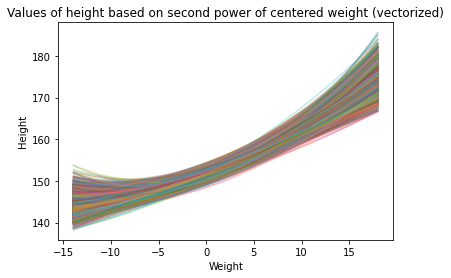

In [80]:
alpha = df['alpha'].values
beta = df['beta'].values
gamma = df['gamma'].values
weigth_vector_lower_bound = np.min(d.c_weight)
weigth_vector_upper_bound = np.max(d.c_weight)
weight_vector = np.linspace(weigth_vector_lower_bound, weigth_vector_upper_bound, N).reshape(N, 1)
heights = alpha + beta * weight_vector + gamma * pow(weight_vector, 2)
plt.plot(weight_vector, heights, alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Values of height based on second power of centered weight (vectorized)")
plt.show()